In [1]:
%matplotlib inline

# Assignment 3

**DUE: Sunday November 7, 2021 11:59pm**

Turn in the assignment via Canvas.

To write legible answers you will need to be familiar with both [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) and [Latex](https://www.latex-tutorial.com/tutorials/amsmath/)

Before you turn this problem in, make sure everything runs as expected. First, restart the kernel (in the menubar, select Runtime→→Restart runtime) and then run all cells (in the menubar, select Runtime→→Run All).

Make sure you fill in any place that says "YOUR CODE HERE" or "YOUR ANSWER HERE", as well as your name below:

In [2]:
NAME = "Miguel Medina"
STUDENT_ID = "1384909"

## Question 1 - Logistic Regression
---
In this question, you will build a system for predicting patient deaths in the Intensive Care Unit (ICU) using the large [PhysioNet Computing in Cardiology Challenge 2012 dataset](https://physionet.org/content/challenge-2012/1.0.0/). For each patient in the dataset, demographic variables and time series of physiological variables were collected during their stay in the ICU. 

The risk prediction system you will build could in principle be used to flag patients as being at risk of death so that physicians could intervene and improve their outcome. To be confident about the impact of such a system, you would need to run an experiment. In this question, you will use a model in order to estimate the potential impact of the system.

The data you will be working with is all available from [PhysioNet](https://physionet.org/challenge/2012/). You will be looking at only the data in "Training set A". The patient data files are [https://archive.physionet.org/challenge/2012/set-a.zip](here), and the outcomes file is [https://archive.physionet.org/challenge/2012/Outcomes-a.txt](here).





#### Downloading and Reading in the Data

First, we download the physiological data and read in patient outcomes file (links above).

We want this data to be read from text files and assembled into a dataframe. To do so, please run the following code which will first define a function that reads a text file, and then runs that function on all the files and assembles the outputs into a single dataframe.

#### Downloading the data

In [3]:
!wget https://archive.physionet.org/challenge/2012/set-a.zip -O ./set-a.zip
import zipfile
with zipfile.ZipFile('./set-a.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

--2021-11-08 04:12:08--  https://archive.physionet.org/challenge/2012/set-a.zip
Resolving archive.physionet.org (archive.physionet.org)... 128.30.30.88
Connecting to archive.physionet.org (archive.physionet.org)|128.30.30.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7938449 (7.6M) [application/zip]
Saving to: ‘./set-a.zip’

./set-a.zip         100%[===================>]   7.57M  22.7MB/s    in 0.3s    

2021-11-08 04:12:08 (22.7 MB/s) - ‘./set-a.zip’ saved [7938449/7938449]



#### Reading in data

In [4]:
import pandas as pd
import numpy as np
import glob

def comp_patient(patdat, attrs):
    patdat[patdat == -1.0] = float('NaN')
    patdat_dict = {}
    for attr in attrs:
        patdat_dict[attr] = [patdat["Value"][patdat["Parameter"]==attr].mean(axis = 0)]
    return patdat_dict


attrs = ["Age", "Gender", "Height", "Weight", "Urine", 
         "HR", "Temp", "NIDiasABP", "SysABP", "DiasABP", "pH",
         "PaCO2", "PaO2", "Platelets", "MAP", "K", "Na", "FiO2", "GCS", "RecordID"]


full_dat  = pd.DataFrame(columns = attrs)

# Now let's take the list "all_pat_dat" and assemble it into a dataframe.
filenames = sorted(glob.glob("/content/set-a/*.txt"))
for filename in filenames:
    data = open(filename)
    patient_dat_full = pd.read_csv(data, delimiter=',')
    patient_dat = pd.DataFrame.from_dict(comp_patient(patient_dat_full, attrs))
    full_dat = full_dat.append(patient_dat)

outcome_dat = pd.read_csv("https://archive.physionet.org/challenge/2012/Outcomes-a.txt")
outcome_dat[outcome_dat == -1] = float('NaN') # set all -1 to NaNs
full_dat_out = full_dat.merge(outcome_dat, left_on='RecordID', right_on='RecordID')
full_dat_out.replace([np.inf, -np.inf], np.nan)

col_means = full_dat_out.mean()
# Set everything that's NaN to the mean of that column:

# Note: we do this for simplicity. Strictly speaking, you should
# only use the training set to compute the column means

for i in range(full_dat_out.shape[1]):
    mask = np.isnan(np.array(full_dat_out.iloc[:,i]))
    full_dat_out.iloc[mask, i] = col_means[i]

### a) Understanding the Data (2 points)
Looking at the files and the code provided above, explain:


*   What is the size of your input data? how many parameters exist in the data?
*   Exaplain what the code provided above is trying to achieve.



*   Looking at the data, there is 4000 entries. So that makes the size of our input 4000. There are 25 features/parameters. These are the ones in list [attrs] plus the 5 added later in the program.
*   The code is creating the data set. It's adding all the columns and removing and unusable entries by filling in spots with the mean of their respective columns. 

### b) Run Logistic Regression (9 points)


Divide your data into training, validation, and test sets (60-20-20). 

Use the features `HR`, `Gender`, `age`, `temperature`, `weight`, `height`, `PaO2`, and  `PaCO2`, and fit a logistic regression model to predict in-hospital death. 

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

x = full_dat_out.drop(columns=['Urine', 'NIDiasABP', 'SysABP', 'DiasABP', 'pH', 'Platelets', 'MAP', 'K', 'Na', 'FiO2', 'GCS', 'RecordID', 'SAPS-I', 'SOFA', 'Length_of_stay', 'Survival', 'In-hospital_death'])
y = full_dat_out.iloc[:, 24]

x = x.values
y = y.values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=140)
x_test, x_validation, y_test, y_validation = train_test_split(x_test, y_test, test_size=0.5, random_state=140)

clf = LogisticRegression().fit(x_train, y_train)
clf = clf.fit(x_train, y_train)

### c) ROC Curve (10 points)

Write a function that, for a given threshold (prob. threshold), calculates both the False Positive Rate (proportion of non-deaths identified as deaths by the model) and True Positive Rate (proportion of deaths correctly identified as such by the model) for your regression model. 

For 100 threshold values equally spaced from 0 to 1, plot the True Positive Rate vs. the False Positive Rate. Use the validation set.

This plot is known as an ROC curve. 


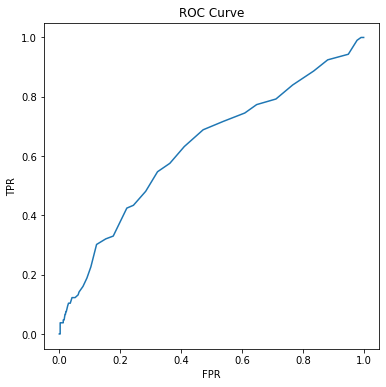

In [6]:
import matplotlib.pyplot as plt

y_predict = clf.predict_proba(x_validation)
y_predict = y_predict[:, 1]

def ROC(real_values, predicted_values, threshold):

  FPR = []
  TPR = []

  for i in range(len(threshold)):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for j in range (len(predicted_values)):
      if predicted_values[j] >= threshold[i]:
        if real_values[j] == 1:
          TP = TP + 1
        else:
          FP = FP + 1
      else:
        if real_values[j] == 1:
          FN = FN + 1
        else:
          TN = TN + 1
    FPR.append(FP / (FP + TN))
    TPR.append(TP / (TP + FN))
  return [FPR, TPR]

threshold = np.linspace(0, 1, 100)

FPR, TPR = ROC(y_validation, y_predict, threshold)

plt.figure(figsize=(6,6))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.plot(FPR, TPR)

### d) Interpreting the ROC Curve (4 points)

Using the plot generated in Part (c), what is the False Positive Rate associated with correctly identifying 80% of patients at risk for death in the ICU? Why might a high false positive rate be appropriate in this setting? You can read the answer off the ROC curve plot.


The FPR at correctly identyfing death at 80% is around 75 - 80%. A high false positive is better in this situation because a doctor would much rather administer aid to someone who might not have needed it, than completely miss someone who was at serious risk of death. 


### e) Modelling Doctors' Decision-Making (6 points)

For this part, produce a short report that answers all the questions below. Include code that produces the numbers that you need.

At the beginning of their shift, a doctor reviews their patients' charts, and decides what intervention is needed for each patient. In the following parts, we will be trying to improve this process. We will consider a simplified version of what is going on. Suppose that if the doctor intervenes correctly, the patient will not die; suppose that the doctor has 60 minutes to look through 25 patient charts; and suppose that the probability of missing the correct treatment if the doctor spends $t$ minutes on reviewing a file is

$$P(\textrm{fail}) = \exp(-t^2/100).$$


1. If the doctor reviews all the files, spends an equal amount of time on each chart, and there are 10 patients who will die without the correct intervention, how many patients are expected to die, if the doctor intervenes when they see that that's needed? What is the percentage of patients who are expected to die, out of 25?

2. Suppose now that the doctor is looking through all the patient charts in the validation set. They would have proportionately more time: $(N/25)\times 60$ minutes in total (where $N$ is the total number of patients in the set). How many patients would be expected to die, if the doctor intervenes correctly when they know they should do that?

3. Now, suppose that the doctor only reviews the files of patients for whom the model outputs a probability of greater than $20\%$. This would give the doctor more time to look through each file, but the doctor would never be able to intervene in the cases of patients form whom the output is $20\%$ or smaller. How many patients would be expected to die?



In [7]:
import math

#First part
t = 60/25
p_fail = math.exp(-(t**2)/100)
d_p = p_fail * 10
print('Percenteage for #1')
print(d_p/25 * 100)

#Second part
t = (800/25)*(60/800)
p_fail = math.exp(-(t**2)/100)
count = 0
for i in range (len(y_validation)):
  if y_validation[i] == 1:
    count = count + 1
d_p = p_fail * count
print('Number of patients for #2')
print(d_p)

#Third part
Above_Twenty = 0
for i in range (len(y_predict)):
  if y_predict[i] >= .20:
    Above_Twenty = Above_Twenty + 1

Unaccounted = 0
for i in range (len(y_predict)):
  if y_predict[i] < .20:
    if y_validation[i] == 1:
      Unaccounted = Unaccounted + 1

Unnecessary_Aid = 0
for i in range (len(y_predict)):
  if y_predict[i] >= .20:
    if y_validation[i] == 0:
      Unnecessary_Aid = Unnecessary_Aid + 1

t = (800/25)*(60/Above_Twenty)
p_fail = math.exp(-(t**2)/100)
d_p = p_fail * (Above_Twenty - Unnecessary_Aid) + Unaccounted
print('Number of patients for #3')
print(d_p)

Percenteage for #1
37.76109931671343
Number of patients for #2
100.06691318929057
Number of patients for #3
77.60484714420785


1. The percentage of patients who are expected to die if the doctor gave every file an equal amount of time is 37.76%. This comes out to about 9 patients. 

---
2. In this problem the doctor still has the issue of having to go through everyones files, leaving a pretty large probability of failing on a patient. Out of the 800 patients the doctor has, about 100 of them would die. 

---
3. Now that the doctor has the help of the machine to better select which file to give attenion to, the fail rate goes significantly lower. Unfortunately, with most thresholds, the doctor will miss at least one patient who did need attention, but the machine was not comfortable enough to flag. Even with the issues of certain patients not getting the necessary treatment, the expected amount of dead patients is about 78 out of the 800. 

### f) Modelling Doctors' Decision-Making - Revisited (7 points)


In this Part, you will explore the policy implications of using our model in an understaffed hospital. 

Suppose that we are considering a policy of only reviewing the files of patients whose probability of death is above a threshold `thr`. Each chart would be given an equal amount of time, and the total amount of time will be $(N/25)\times 60$.

Using the model from previous part, plot the total number of expected deaths under the policy vs. the threshold. Using the plot, what is the best threshold to use that would minimize the number of deaths?

You should compute the expected number of deaths for the thresholds `np.arange(0, 1, 0.01)`.

Use the validation set.




76.58022112065679


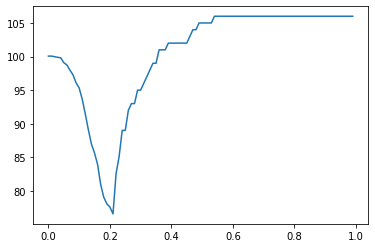

In [8]:
threshold = np.arange(0, 1, 0.01)

def policy(y_validation, y_predict, threshold):

  Expected_D = []

  for j in range(len(threshold)):
    Above_Threshold = 0
    for i in range (len(y_predict)):
      if y_predict[i] >= threshold[j]:
        Above_Threshold = Above_Threshold + 1

    Unaccounted = 0
    for i in range (len(y_predict)):
      if y_predict[i] < threshold[j]:
        if y_validation[i] == 1:
          Unaccounted = Unaccounted + 1

    Unnecessary_Aid = 0
    for i in range (len(y_predict)):
      if y_predict[i] >= threshold[j]:
        if y_validation[i] == 0:
          Unnecessary_Aid = Unnecessary_Aid + 1

    if Above_Threshold == 0:
      Expected_D.append(Unaccounted)
    else:
      t = (800/25)*(60/Above_Threshold)
      p_fail = math.exp(-(t**2)/100)
      d_p = p_fail * (Above_Threshold - Unnecessary_Aid) + Unaccounted
      Expected_D.append(d_p)
  return Expected_D

#print(y_predict)

Expected_D = policy(y_validation, y_predict, threshold)

plt.plot(threshold, Expected_D)
print(min(Expected_D))


Just as it was seen in the last problem, there is a certain "sweet spot" that 0gives the doctor the most time to look at the files of patients who need attention, while minimizing the amount of untreated patients who would die without it. As the graph shows, missing the threshold gives a pretty drastic difference in the number of dead patients. The best threshold my model found was at 21% having about 77 patients die out of the 800. 

### g) Modelling Doctors' Decision-Making - Testing (7 points)

On the test set, compare the total number of expected deaths under the best policy that was selected in Part (f) to reviewing each patient's file. In relative terms (i.e., as a percentage), how many lives would be saved, if the assumptions underlying our simulation are accurate?

In [55]:
#Reviewing each patients file
t = (800/25)*(60/800)
p_fail = math.exp(-(t**2)/100)
count = 0
for i in range (len(y_test)):
  if y_test[i] == 1:
    count = count + 1
d_p_all = p_fail * count
print('Number of patients reviewing every file')
print(d_p_all)
print(d_p_all/800*100,'%')



#Using best policy of .21 threshold
y_predict_test = clf.predict_proba(x_test)
y_predict_test = y_predict_test[:, 1]

Above_Twentyone = 0
for i in range (len(y_predict_test)):
  if y_predict_test[i] >= .21:
    Above_Twentyone = Above_Twentyone + 1

Unaccounted = 0
for i in range (len(y_predict_test)):
  if y_predict_test[i] < .21:
    if y_test[i] == 1:
      Unaccounted = Unaccounted + 1

Unnecessary_Aid = 0
for i in range (len(y_predict_test)):
  if y_predict_test[i] >= .21:
    if y_test[i] == 0:
      Unnecessary_Aid = Unnecessary_Aid + 1

t = (800/25)*(60/Above_Twentyone)
p_fail = math.exp(-(t**2)/100)
d_p_best = p_fail * (Above_Twentyone - Unnecessary_Aid) + Unaccounted
print('Number of patients using best policy')
print(d_p_best)
print(d_p_best/800*100,'%')

print('Difference in lives saved ')
print(d_p_all - d_p_best)
print(100 - d_p_best/d_p_all*100,'%')

Number of patients reviewing every file
110.45121550138677
13.806401937673346 %
Number of patients using best policy
85.30111864045396
10.662639830056746 %
Difference in lives saved 
25.150096860932805
22.770321491497782 %


Using the best policy over looking at all the files in the test set gives the doctor the opportunity to save about 25 more lives. In comparing the two, 22% less patients died with the best policy model. 

## Question 2 - Neural Networks
---

We will train a fully connected neural networks to recognize face images of cats and dogs. 

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [10]:
data_dir = 'pets'
image_width = 32
image_height = 32
batch_size = 10

### a) Load the Pets Dataset (2 points)
There are 110 images of size $32\times32$. Run the following code block to import the data. Keep in mind that they will be downloaded from the internet, so it may take a while.

In [11]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [12]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [13]:
# Download the data
downloaded = drive.CreateFile({'id':"1cA-dQ4tXusV0hQLK3JieI8GXQdvxNwbs"})
downloaded.GetContentFile('pets.npy')  
data = np.load("pets.npy",allow_pickle=True)

In [14]:
# Create X and y
X, y = (data[()]['X'], data[()]['y'])

In [15]:
# Get class names and create ID
class_names = ['cat', 'dog']
class_dict = {i:class_name for i,class_name in enumerate(class_names)}

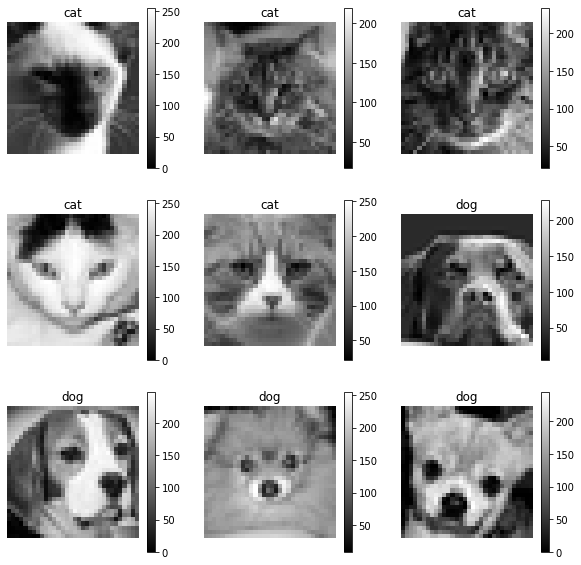

In [16]:
# Plot some images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for count, i in enumerate(range(0,110, 13)):
    ax = plt.subplot(3, 3, count + 1)
    plt.imshow(X[i],cmap='gray')
    plt.colorbar()
    plt.title(class_names[y[i]])
    plt.axis("off")

Answer the following questions:

1.) What are the data types for X and y?

2.) What are the shapes of X and y?

3.) What is the minimum and maximum value of X?

1) Both X and y have data types of the numerical category. X Are a gradient in the greyscale and y is classification between cats and dogs.

---
2) X is an array with arrays nested inside, in this case a 3-D array. There are 110 entries in X, each entry having 32 arrays of length 32. y is an array of length 110. 

---
3) Minimum is 0 and maximimum is 255.

### b) Data Preprocessing (3 points)
As you can see above, the pixel values are in the [0,255]. This is the normal range for images. Recall from the previous lectures and excercises that we need to normalize our data.

In order to normalize our data to [0,1] we use the equation:

$$x_{norm}=\frac{x-x_{min}}{x_{max}-x_{min}}$$

In our case we can assume that $x_{min}=0$ and $x_{max}=255$, this is a safe assumption since we are working with image data.

This means that for image data, if we want to normlize to [0,1] the equation simplifies to:

$$img_{norm}=\frac{img}{255}$$

Anytime you work with image data in any kind of model you will be normalizing with this equation. Unless the range you want to normalize is different. Sometimes you want to normalize between [-1,1], for that you would use a slightly different equation.


Normalize the X data using the above equation and save as train_images.

In [17]:
train_images =  X/255

If we show the image agian, you will see the values are all scaled correctly.

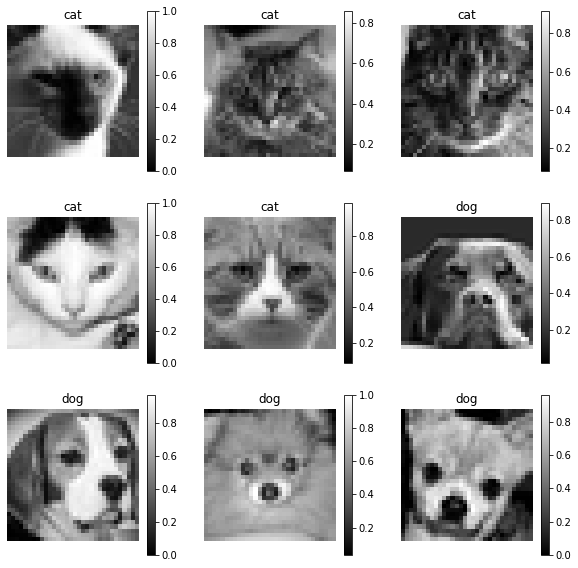

In [18]:
# Plot images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for count, i in enumerate(range(0,110, 13)):
    ax = plt.subplot(3, 3, count + 1)
    plt.imshow(train_images[i],cmap='gray')
    plt.colorbar()
    plt.title(class_names[y[i]])
    plt.axis("off")

What is the new minimum and maximum value of X?

New mimimum is still 0, while the new maximum is now 1.

### c) Reshaping the Data (5 points)

Please reshpe training images to be 1024-dim (from $32 \times 32$). 

Hint: look into numpy.reshape().


In [19]:
print(f'Before reshape, train_images shape: {train_images.shape}')

train_images = train_images.reshape((110, 1024))

print(f'Before reshape, train_images shape: {train_images.shape}')


Before reshape, train_images shape: (110, 32, 32)
Before reshape, train_images shape: (110, 1024)


### d) Building a Simple Neural Network (15 points)
In the cell below, build a fully-connected feed-forward neural network with the following layers:
* **input layer** of shape 1024
* **hidden layer** with 25 neurons, and relu activation
* **output layer** with 1 neuron, and sigmoid activation

In [20]:
from tensorflow.keras.layers import Input, Dense 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import *

# Build neural network
def build_model1(): 
  model = Sequential() 
  model.add(Dense(units = 1024, input_dim = 1024)) 
  model.add(Dense(units = 25, activation='relu')) 
  model.add(Dense(units = 1, activation='sigmoid')) 
  return model

model = build_model1()

In [21]:
# Show a summary of your model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
dense_1 (Dense)              (None, 25)                25625     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 26        
Total params: 1,075,251
Trainable params: 1,075,251
Non-trainable params: 0
_________________________________________________________________


Declare the optimizer using Stochastic Gradient Descient with learning rate of 0.001, weight decay of 1e-6 and momentum of 0.009. Compile your model using the 'binary_crossentropy' loss function and 'accuracy' as the metrics.

In [22]:
# Declare optimizer
optimizer =  SGD(lr=0.001, decay=1e-6, momentum=0.009)

# Compile model
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Now we will train our model to learn pet faces using train_images and the 'y' labels. Our dataset is small so we will use 10% of the data as test set data. Train your model using the following parameters:

Fit your model using the train_images, 'y' labels, a batchsize of 10, and validation split of 0.1. Train for 500 epochs.

.fit documentation: https://www.tensorflow.org/api_docs/python/tf/keras/Model

In [23]:
y = y.reshape(-1,1)

# Call fit on your model passing in the X, y data above, train for 500 epochs
hist =  model.fit(train_images,
                  y, 
                  epochs=500, 
                  batch_size=10, 
                  validation_split=0.1)

Epoch 1/500
10/10 [==============================] - 1s 26ms/step - loss: 0.7052 - accuracy: 0.5253 - val_loss: 0.7056 - val_accuracy: 0.5455
Epoch 2/500
10/10 [==============================] - 0s 8ms/step - loss: 0.6719 - accuracy: 0.5556 - val_loss: 0.7187 - val_accuracy: 0.6364
Epoch 3/500
10/10 [==============================] - 0s 7ms/step - loss: 0.6526 - accuracy: 0.6061 - val_loss: 0.6701 - val_accuracy: 0.6364
Epoch 4/500
10/10 [==============================] - 0s 8ms/step - loss: 0.6401 - accuracy: 0.6364 - val_loss: 0.6885 - val_accuracy: 0.6364
Epoch 5/500
10/10 [==============================] - 0s 7ms/step - loss: 0.6262 - accuracy: 0.6566 - val_loss: 0.6634 - val_accuracy: 0.6364
Epoch 6/500
10/10 [==============================] - 0s 7ms/step - loss: 0.6135 - accuracy: 0.6970 - val_loss: 0.6466 - val_accuracy: 0.6364
Epoch 7/500
10/10 [==============================] - 0s 9ms/step - loss: 0.6084 - accuracy: 0.6869 - val_loss: 0.6165 - val_accuracy: 0.7273
Epoch 8/500


In [24]:
def plot_losses(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()
def plot_accuracies(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

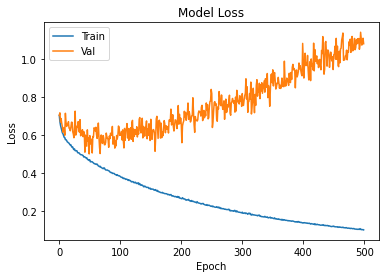

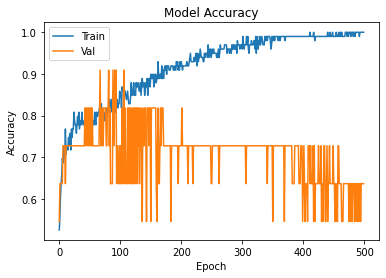

In [25]:
# plot your losses and accuracies
plot_losses(hist)
plot_accuracies(hist)

For the input size, this one hidden layer neural network is probably too small. However, we can see that the model attempts to minimize the overall loss. Summarize your observations on the model's learning curves, model's overall classification accuracy on the validation set, and the least amount of loss on validation set?

In [26]:
print(min(hist.history['val_loss']))
print(max(hist.history['val_accuracy']))

0.5020128488540649
0.9090909361839294


While the model starts off with decent speed, it begins to lose steam around 75 epochs. For both loss and accurracy, the model only gets marginally better after that 75th one. Even so that the loss actually gets worse the higher into the epochs we get. The model stays pretty comfortably at 0.6364 accuracy near the end of its runs. Again, around the 75th epoch is where it begins to go into a rhythm. It fluctuates with around a 0.1 range both positively and negatively. The minimum value on val_loss is 0.5020128488540649. The maximum value for val_accuracy is 0.9090909361839294. I believe that is a pretty good accuracy, might be sign of overfitting why it goes bad in such greater epochs.  

### e) Building a Second Neural Network (15 points)
Next, you will build a neural network with one hidden layer that is wider than the previous model's hidden layer. In the cell below, build a neural network with the following layers:
* **input layer** of shape 1024
* **hidden layer** with 100 neurons, and relu activation
* **output layer** with 1 neuron, and sigmoid activation

In [27]:
# Build Neural network
def build_model2(): 
  model = Sequential() 
  model.add(Dense(units = 1024, input_dim = 1024)) 
  model.add(Dense(units = 100, activation='relu')) 
  model.add(Dense(units = 1, activation='sigmoid')) 
  return model

model = build_model2()

In [28]:
# Show a summary of your model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_4 (Dense)              (None, 100)               102500    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 1,152,201
Trainable params: 1,152,201
Non-trainable params: 0
_________________________________________________________________


Again, declare the optimizer using Stochastic Gradient Descient with learning rate of 0.001, weight decay of 1e-6 and momentum of 0.009. Compile your model using 'binary_crossentropy' loss function and 'accuracy' as the metrics.

In [29]:
# Declare optimizer
optimizer =  SGD(lr=0.001, decay=1e-6, momentum=0.009)

# Compile model
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In this sell fit your model using the train images, y labels, a batchsize of 10, and validation split of 0.1. Train for 500 epochs.

In [30]:
y = y.reshape(-1,1)

# Call fit on your model passing in the X, y data above, train for 500 epochs
hist = model.fit(train_images,
                  y, 
                  epochs=500, 
                  batch_size=10, 
                  validation_split=0.1)

Epoch 1/500
10/10 [==============================] - 1s 24ms/step - loss: 0.7146 - accuracy: 0.4545 - val_loss: 0.6788 - val_accuracy: 0.4545
Epoch 2/500
10/10 [==============================] - 0s 9ms/step - loss: 0.6707 - accuracy: 0.6162 - val_loss: 0.7184 - val_accuracy: 0.4545
Epoch 3/500
10/10 [==============================] - 0s 9ms/step - loss: 0.6571 - accuracy: 0.6364 - val_loss: 0.7478 - val_accuracy: 0.4545
Epoch 4/500
10/10 [==============================] - 0s 8ms/step - loss: 0.6486 - accuracy: 0.6768 - val_loss: 0.7535 - val_accuracy: 0.3636
Epoch 5/500
10/10 [==============================] - 0s 11ms/step - loss: 0.6350 - accuracy: 0.6667 - val_loss: 0.7425 - val_accuracy: 0.3636
Epoch 6/500
10/10 [==============================] - 0s 9ms/step - loss: 0.6275 - accuracy: 0.6768 - val_loss: 0.7588 - val_accuracy: 0.3636
Epoch 7/500
10/10 [==============================] - 0s 9ms/step - loss: 0.6261 - accuracy: 0.6566 - val_loss: 0.7381 - val_accuracy: 0.3636
Epoch 8/500

In [31]:
def plot_losses(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()
def plot_accuracies(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

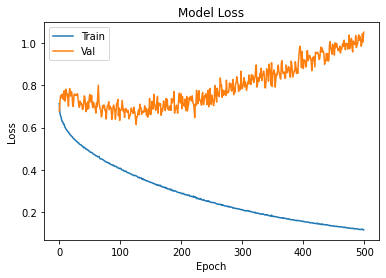

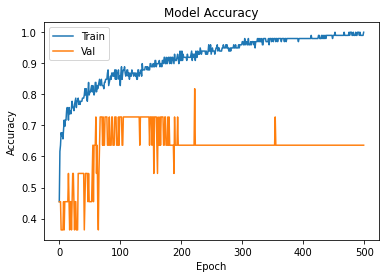

In [32]:
# Plot your losses and accuracies
plot_losses(hist)
plot_accuracies(hist)

Next, summarize this models results. Consider the following questions when answering. Remember that this model has a higher learning capacity than the previous model. 

1) How did this model compare to previous model? 

2) Did it outperform the previous models? 

3) What was your model's overall classification accuracy on the validation set and the least amount of loss on validation set? 

In [33]:
print(min(hist.history['val_loss']))
print(max(hist.history['val_accuracy']))

0.6145354509353638
0.8181818127632141


In both loss and accuracy, this model performed worse. This was not only for the final value, but also for the min and maxes. Having a fatter hidden layer didn't seem to make the impact I was expecting it to. There are still signs of overfitting that begin around the 75th epoch. Other than having different values, both this and the previous graphs seem to follow the same general shape. The val_loss minimum is 0.6145354509353638 and the val_accuracy maximum is 0.8181818127632141.

### f) Building a Third Neural Network (15 points)
Lastly, you will build a fully-connected neural network with two hidden layers. In the cell below, build a neural network with the following layers:
* **input layer** of shape 1024
* **hidden layer** with 100 neurons, and relu activation
* **hidden layer** with 25 neurons, and relu activation
* **output layer** with 1 neuron, and sigmoid activation

In [34]:
from tensorflow.keras.layers import Input, Dense # only use these layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import * # you can use any optimizer

# Build Neural network
def build_model3(): 
  model = Sequential() 
  model.add(Dense(units = 1024, input_dim = 1024))
  model.add(Dense(units = 100, activation='relu'))
  model.add(Dense(units = 25, activation='relu'))
  model.add(Dense(units = 1, activation='sigmoid'))
  return model

model = build_model3()

In [35]:
# Show a summary of your model
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_7 (Dense)              (None, 100)               102500    
_________________________________________________________________
dense_8 (Dense)              (None, 25)                2525      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 26        
Total params: 1,154,651
Trainable params: 1,154,651
Non-trainable params: 0
_________________________________________________________________


Since this model is bigger than the previous models, we will use a more powerful optimizer. Declare the optimizer as Adam with learning rate of 0.001. Compile your model using 'binary_crossentropy' loss function and 'accuracy' as the metrics.

In [36]:
# Declare optimizer
optimizer =  Adam(learning_rate=0.001)

# Compile model
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In this sell fit your model using the train images, y labels, a batchsize of 10, and validation split of 0.1. Train for 500 epochs.

In [37]:
y = y.reshape(-1,1)

# Call fit on your model passing in the X, y. 
# Train for 500 epochs with a batch size of 10 and validation split of 0.1
hist = model.fit(train_images,
                  y, 
                  epochs=500, 
                  batch_size=10, 
                  validation_split=0.1)

Epoch 1/500
10/10 [==============================] - 1s 25ms/step - loss: 0.9250 - accuracy: 0.5152 - val_loss: 2.3581 - val_accuracy: 0.0000e+00
Epoch 2/500
10/10 [==============================] - 0s 12ms/step - loss: 0.8145 - accuracy: 0.4646 - val_loss: 0.7558 - val_accuracy: 0.2727
Epoch 3/500
10/10 [==============================] - 0s 10ms/step - loss: 0.5890 - accuracy: 0.7071 - val_loss: 0.9320 - val_accuracy: 0.1818
Epoch 4/500
10/10 [==============================] - 0s 10ms/step - loss: 0.6389 - accuracy: 0.6566 - val_loss: 1.3172 - val_accuracy: 0.0000e+00
Epoch 5/500
10/10 [==============================] - 0s 11ms/step - loss: 0.5755 - accuracy: 0.6869 - val_loss: 0.8486 - val_accuracy: 0.3636
Epoch 6/500
10/10 [==============================] - 0s 10ms/step - loss: 0.4782 - accuracy: 0.7475 - val_loss: 0.5287 - val_accuracy: 0.9091
Epoch 7/500
10/10 [==============================] - 0s 10ms/step - loss: 0.4710 - accuracy: 0.8182 - val_loss: 0.3455 - val_accuracy: 0.909

In [38]:
def plot_losses(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()
def plot_accuracies(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

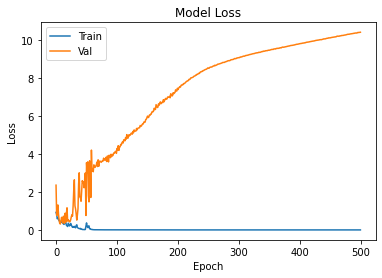

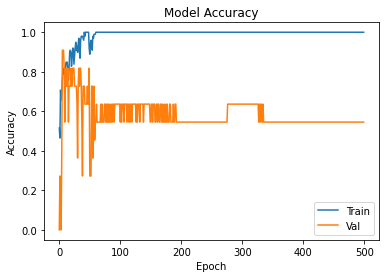

In [39]:
# plot your losses and accuracies
plot_losses(hist)
plot_accuracies(hist)

Summarize this model's results. Consider the following when answering:

1) How did this model compare to previous models? 

2) Did it outperform the previous models? 

3) What was your model's overall classification accuracy on the validation set and the least amount of loss on validation set? 

4) Adam is a powerful optimizer, and may quickly converge to an a minima. Did this happen with this model?

In [40]:
print(min(hist.history['val_loss']))
print(max(hist.history['val_accuracy']))

0.3115570843219757
0.9090909361839294


This model is much more distinguishable than the other two models. What I found most interesting was the loss of this model. It shoots up to an insane amount at over 10. Also, unlike the other two models, the val accuracy begins pretty close to 0. This model moves so much "faster" at getting its predictions. It reaches its respective minimums and maximums almost immediately and begins to overfit quicker. Adam definitely helped give the model a boost in the right direction. If we didn't have to give 500 epochs and could instead choose our variable, this model would be the best and fastest performing. The minimum val_loss is 0.3115570843219757 and the maximum accuracy is 0.9090909361839294. While the accuracy is somehow the same to the one in the first model, this gets to the lowest loss of all three models. 